In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
import torch
from produce_NA import *
import numpy.linalg as LA


In [2]:
def nan_covariance(data): #not sure how to initialise without a function like this, np.cov() does not work well as there is alot of NaN in the matrix
    n, m = data.shape # this function basicaly computes covariance ignoring the mssiing data
    mean_cols = np.nanmean(data, axis=0)
    cov_matrix = np.empty((m, m))

    for i in range(m):
        for j in range(m):
            valid_data = ~np.isnan(data[:, i]) & ~np.isnan(data[:, j])
            centered_i = data[valid_data, i] - mean_cols[i]
            centered_j = data[valid_data, j] - mean_cols[j]
            cov_matrix[i, j] = np.mean(centered_i * centered_j)

    return cov_matrix

In [3]:
def log_likelihood1(X, mu, Sigma):
    N=X.shape[0]
    p=X.shape[1]
    result=-N/2*np.log(np.linalg.det(Sigma))
    X_muT=X-mu.T
    for n in range(N):
        result=result-0.5*(X[n,:]-mu.T).dot(np.linalg.solve(Sigma, X[n,:].T-mu)) #is repetitively summing here bad?
    return result

In [4]:
def calculate_xhat(xn,mu,Sigma,missing_indices):
    #m=missing_indices.shape[0]
    p=Sigma.shape[0]
    
    xhatn=xn.copy()
    observed_indices=np.arange(p)[~np.isin(np.arange(p),missing_indices)]
    #appended_indices=np.append(observed_indices, missing_indices)
    
    Sigma22=Sigma[missing_indices,:][:,missing_indices]
    Sigma11=Sigma[observed_indices,:][:,observed_indices]
    Sigma21=Sigma[missing_indices,:][:,observed_indices]
    
    mu1=mu[observed_indices]
    mu2=mu[missing_indices]
    xhatn_1=xhatn[observed_indices]
    mu2_conditional=mu2+Sigma21.dot(np.linalg.solve(Sigma11,xhatn_1-mu1))
    #print(xhatn)
    #print(mu2_conditional,xhatn[missing_indices,],mu2_conditional.shape,xhatn[missing_indices,].shape)
    xhatn[missing_indices,] = mu2_conditional
    #this doesnt seem to work 
    #reason: Array is passed as a view, potential danger!
    #hmm still doesnt work wtf
    #Its because a numpy array of ints rounds floats that are added to it wtfffff, fixed now
    
    #print(xhatn.base)
    #print(mu2_conditional,xhatn[missing_indices])
    
    return xhatn

In [5]:
def calculate_C(Sigma,missing_indices,verbose=False):
    p=Sigma.shape[0]
    m=missing_indices.shape[0]
    if verbose:
        print("Original unconditional covariance : \n",Sigma)
    observed_indices=np.arange(p)[~np.isin(np.arange(p),missing_indices)]
    appended_indices=np.append(observed_indices, missing_indices)
    Sigma=(Sigma[appended_indices,:])[:,appended_indices]
    
    if verbose:
        print("Unconditional covariance rearranged so that missing indices are at the bottom : \n",Sigma)
    Sigma11=Sigma[0:(p-m),0:(p-m)]
    Sigma21=Sigma[(p-m):p,0:(p-m)]
    Sigma22=Sigma[(p-m):p,(p-m):p]
    Sigma22_conditional=Sigma22-Sigma21.dot(np.linalg.solve(Sigma11,Sigma21.T))
    
    reverse_permutation=np.argsort(appended_indices)
    result=np.full((p,p),0)
    result[(p-m):p,(p-m):p]=Sigma22_conditional
    if verbose:
        print("The conditional covariance when ordered is : \n",result)
    result=(result[reverse_permutation,:])[:,reverse_permutation]
    if verbose:
        print("After permuting back we get : \n", result)
    return(result)

In [6]:
def em_algorithm1(data, max_iter=100, tol=1e-6):
    n, p = data.shape

    # Initialize mean and covariance estimates
    means = np.nanmean(data, axis=0)
    covariance = nan_covariance(data)

    # Create an array to hold imputed data
    imputed_data = np.where(np.isnan(data), np.nanmean(data, axis=0), data)
    #imputed_data = np.where(np.isnan(data), None, data)
    
    old_log_likelihood = log_likelihood1(imputed_data, means, covariance)
    #print(old_log_likelihood)

    for iteration in range(max_iter):
        # E-step: Estimate missing values
        for i in range(n):
            missing = np.where(np.isnan(data[i]))[0]
            if np.isnan(data[i]).any():
                imputed_data[i,] = calculate_xhat(imputed_data[i,],means,covariance,missing) #this function works with Nans in the missing entries too, why do we impute?

        # M-step: Update mean and covariance estimates
        means = np.mean(imputed_data, axis=0)
        new_covariance = np.full((p,p),0) 

        # Add the conditional covariance for missing data
        for i in range(n):
            missing = np.where(np.isnan(data[i]))[0]
            #if missing.any(): #with this condition, are you not skipping xhat-mu *(xhat-mu).T when there is no missing data? I think so...
            new_covariance = new_covariance + calculate_C(covariance,missing,verbose=False) + (imputed_data[i,]-means).reshape(-1, 1) @ np.transpose((imputed_data[i,]-means).reshape(-1, 1))
            
        covariance = new_covariance/n 
        #print(covariance)
        # Convergence test based on log likelihood
        new_log_likelihood = log_likelihood1(imputed_data, means, covariance)
        #print(new_log_likelihood)
        difference=new_log_likelihood - old_log_likelihood
        #print("The new log likelihood is :", new_log_likelihood, "  Difference of : ",difference)
        
        if np.abs(difference) < tol: #absolute value not necessary and potentially undesirable, as in theory should always be positive
            #print("Convergence achieved! \n")
            break
        old_log_likelihood = new_log_likelihood

    return imputed_data,means,covariance

In [7]:
# Function to generate synthetic data
def generate_synthetic_data(n_samples=1000, n_features=5):
    mean = np.random.rand(n_features) * 10
    cov = np.random.rand(n_features, n_features)
    cov = np.dot(cov, cov.transpose())  # Ensure the covariance matrix is positive semi-definite
    data = multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples)
    return data

In [8]:
# Generate synthetic data
data = generate_synthetic_data(n_samples=1000, n_features=5)
missing_data_info = produce_NA(data, 0.2 , mecha="MCAR")
X_incomp = missing_data_info['X_incomp'].numpy()



In [9]:
imputed_data, _, _ = em_algorithm1(X_incomp)

In [11]:
print(mean_squared_error(data, imputed_data))

0.05393243097289543


C:\Users\charl\AppData\Local\Temp\ipykernel_27720\893035607.py:4: RuntimeWarning: invalid value encountered in log
  result=-N/2*np.log(np.linalg.det(Sigma))


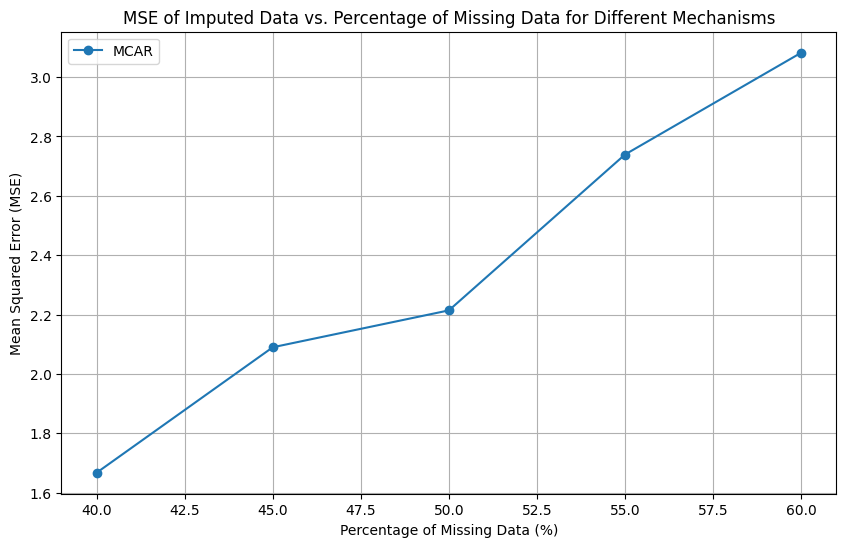

In [23]:
# Function to generate synthetic data
def generate_synthetic_data(n_samples=1000, n_features=5):
    mean = np.random.randn(n_features) * 10
    cov = np.random.randn(n_features, n_features)
    cov = np.dot(cov, cov.transpose())  # Ensure the covariance matrix is positive semi-definite
    data = multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples)
    return data

# Generate synthetic data
data = generate_synthetic_data(n_samples=1000, n_features=5)

# Range of missing data percentages and mechanisms
missing_data_percentages = np.arange(40, 65, 5)
missing_mechanisms = ["MCAR"]#, "MAR", "MNAR", "MNARsmask"]
mse_values = {mechanism: [] for mechanism in missing_mechanisms}

# Loop over different missing data mechanisms and percentages
for mechanism in missing_mechanisms:
    for p_miss in missing_data_percentages:
        # Simulate missing data
        missing_data_info = produce_NA(data, p_miss / 100.0, mecha=mechanism)
        X_incomp = missing_data_info['X_incomp']

        # Convert PyTorch tensor to NumPy array if necessary
        if isinstance(X_incomp, torch.Tensor):
            X_incomp = X_incomp.numpy()

        # Apply EM algorithm
        imputed_data, _, _ = em_algorithm1(X_incomp)

        # Calculate MSE
        mse = mean_squared_error(data, imputed_data)
        mse_values[mechanism].append(mse)

# Plotting the results
plt.figure(figsize=(10, 6))
for mechanism in missing_mechanisms:
    plt.plot(missing_data_percentages, mse_values[mechanism], marker='o', label=mechanism)

plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Imputed Data vs. Percentage of Missing Data for Different Mechanisms')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
np.arange(40, 65, 5)

array([40, 45, 50, 55, 60])

Estimateurs plus robusres de Sigma
Perturbation à 

cacthc and try

differentes covariance structures
différentes dépendantes dans la matrice de covariance
sparsité dans matrice de covariance

Simuler des spacial data 
Matem covariance function